In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from keras.models import load_model
import modules.deep_model as DeepModel
import modules.model as Model 
import warnings
import numpy as np
import os

warnings.filterwarnings('ignore')

## Công việc 2.2 (Tiếp theo):
* Ở phần này, chúng ta sẽ xây dựng một **Comment sentiment model** bằng LSTM.
* Chúng ta biết rằng hạn chế của RNN là nó không thể lưu trữ các thông tin trong dài hạn - RNN tiến hành lưu trữ các thông tin mà nó học được từ chuỗi vào các **hidden state** nhưng khi chuỗi đầu vào quá dài - nó sẽ không thể giữ lại các thông tin này do vấn đề **gradient-vanishing** [tiêu biến gradient] trong quá trình backpropagation:<br>
  ![](./images/14.png)
* LSTM ra đời để khắc phục gradient-vanishing bằng một cấu trúc đặc biệt gọi là **gate**. Gate sẽ lưu các thông tin của chuỗi lại đồng thời nó quản lí được thông tin nào nên xóa khỏi bộ nhớ và thông tin nào cần giữ.
* Giả sử chúng ta có câu: **Giao hàng nhanh**. Với RNN nó dễ dàng dự đoán được comment này thuộc class positive. Nhưng giả sử ta có câu dài hơn: **Giao hàng chậm "nhưng" hàng đẹp - cảm ơn shop**. Thì câu hỏi đặt ra là làm sao RNN có thể lưu trữ các thông tin trước từ **nhưng** là negative word và phía sau là positive word. RNN sẽ không thể lưu trữ các thông tin này do vấn đề vanishing-gradient. Nhưng với LSTM nó sẽ giảm bớt hiện tượng này nhờ sử dụng một cấu trúc là LSTM cell. <br>
  ![](./images/15.png)
* Lúc này, mỗi LSTM cell sẽ chứa ba gate lần lượt là:
  * **Input gate**: quyết định thông tin nào cần được thêm vào từ chuỗi đầu vào.
  * **Output gate**: quyết định thông tin nào cần được lưu trữ
  * **Forget gate**: thông tin nào cần được loại bỏ.
  
  ![](./images/16.png)

* Ở RNN, một hidden state được sử dụng cho hai mục đích là lưu trữ thông tin và đưa ra dự đoán. Tuy nhiên ở LSTM nó tách hiddent state thành hai phần là:
  * **Cell state**: đây là nơi lưu giữ thông tin.
  * **Hidden state**: dùng cho việc dự đoán.
* Cell state và hidden state chia sẻ thông tin lẫn nhau. Như hình trên ta thấy đầu vào sau khi đi qua hidden state $\rightarrow$ qua các gate $\rightarrow$ đến cell state.

Bây giờ chúng ta sẽ tiến hành xây dựng một **Comment sentiment model** sử dụng LSTM của TensorFlow.

Load dữ liệu training.

In [3]:
X_train, y_train = Model.loadData("./data/data/train")
X_train = X_train.fillna("")

X_test, y_test = Model.loadData("./data/data/test")
X_test = X_test.fillna("")

display(X_train, y_train)
display(X_test, y_test)

,raw_comment,normalize_comment,emoji_decode
0,Shop gói hàng chắc chắn. Giai hàng nhan...,gói hàng chắc chắn giai hàng nhanh màu...,
1,Chất liệu vải thì khỏi bàn. Chỉ mỗi...,chất liệu vải khỏi bàn chỉ mỗi may đ...,
2,kẹp đẹp dã mannnnnnnnnnnnnnnnnnnnnnnnnnnnnn...,kẹp đẹp dã,
3,Áo ko đúng size\nSiza xl mà như size m v,áo không đúng size xl mà như size,
4,Với giá thì sp khá tốt\nNhưng lông ho...,giá sản phẩm khá tốt nhưng lông hơi ...,
...,...,...,...
11356,Áo cũng ok nhưng vải nóng quá,áo cũng ok nhưng vải nóng quá,
11357,quần đẹp mà áo thì hơi mỏng,quần đẹp mà áo hơi mỏng,
11358,"Khóa bị kẹt, kéo qua lại k mượt. Nói ...",kẹt kéo qua không mượt nói chung tạm o...,
11359,Đặt hàng lần thứ nhất shop giao thiê...,đặt hàng lần thứ nhất giao thiếu mo...,


,label
0,1
1,0
2,1
3,0
4,0
...,...
11356,0
11357,1
11358,0
11359,0


,raw_comment,normalize_comment,emoji_decode
0,"Đẹp , nhẹ , đường may nhiều đầu chỉ ...",đẹp nhẹ đường may nhiều đầu chỉ các...,
1,Giao hàng nhanh\nĐóng gói sản phẩm cẩn...,giao hàng nhanh đóng gói sản phẩm cẩn ...,
2,Quần đẹp lắm \nShop thân thiện \nNhiê...,quần đẹp lắm thân thiện nhiều o,
3,"Uiii, xinhhhhh lắmmmmmm luônnnnn, ship nhan...",ui xinh lắm luôn ship nhanh nưa,
4,Chất lượng tốt giao hàng nhanh nhân v...,chất lượng tốt giao hàng nhanh nhân v...,thumbsup thumbsup thumbsup thumbsup thumbsup
...,...,...,...
2836,Chất hơi bị mềm quá. Nc vẫn đc.,chất hơi mềm quá nói chuyện vẫn đư...,
2837,Nhìn hình tưởng quần dày có thể mạ...,nhìn hình tưởng quần dày có thể mạ...,
2838,Sản phẩm bị lủng rách nhiều chổ mua ...,sản phẩm lủng rách nhiều chổ mua cái...,
2839,Cay vừa mua 180k hôm sau giảm 120k,cay vừa mua không hôm sau giảm không,


,label
0,0
1,1
2,1
3,1
4,1
...,...
2836,1
2837,0
2838,0
2839,1


Ở đây, nhóm đã viết gọn tất cả các tính năng của một LSTM model vào một object là `SentimentLSTM` nằm trong file `deep_model.py`, về ý tưởng của nhóm như sau:
  * **Bước 1**: Dữ liệu training ở đây là các comment đã qua bước tiền xử lí ở feature `normalize_comment` - ta bỏ qua không cần xử lí N-Grams cho feature này.
  * **Bước 2**: Ta sử dụng cơ chế Tokenizer do TensorFlow cung cấp, object `Tokenizer` của TensorFlow yêu cầu một hyper-pamrameter là `num_words` - tức số lượng từ tối đa ta muốn tokenize, ở đây nếu để bằng `None`, `Tokenizer` sẽ được tự động tính. Cuối cùng `Tokenizer` sẽ lưu các comment dưới dạng mảng chứa các index của từ, với index của từ phổ biến nhất là 1.
  * **Bước 3**: Ta sử dụng phương thức `pad_sequences()` của TensorFlow - phương thức này sẽ dựa vào thuộc tính `maxlen` để đưa toàn bộ các comment về cùng một độ dài, các comment nào có chiều dài lớn sẽ được cắt bớt. Các comment ngắn hơn sẽ được thay thế bằng giá trị 0.
  * **Bước 4**: Ta sẽ định nghĩa kiến trúc của model trong `SentimentLSTM._defineModel()`. Ở đây, để tiện cho quá trình HyperParams Optimization, ta sẽ để thuộc tính `optimizer` linh động dựa trên tham vào truyền vào của hàm. Tiếp theo, ở output ta sử dụng 2 neuron để lưu giá trị của xác suất để dự đoán comment đó ở lần lượt hai class là negative và positive, ta sử dụng loss function là **binary cross-entropy** và action function **softmax** cho output layer này.
  * **Bước 5**: Để ta có thể kiểm soát được liệu model có bị overfitting trong quá trính training không, nếu có ta có thể dừng quá trình training lại. Tại đây ta sử dụng object `CheckPoint` do TensorFlow cung cấp, object này sẽ theo dõi qua trình training và dựa vào thông số trên loss function mà ta chỉ định là trên train hay validation data để tiến hành lưu lại **weights set** của model tại thời điểm loss value này thấp nhất, ở đây nhóm sẽ sử dụng 10% dữ liệu training làm validation và chỉ định validation loss để tránh overfitting.

Code dưới đây ta sẽ định nghĩa một hyperparams set cho model. Ở đây `num_words` và `maxlen` là `None` để cho TensorFlow tự tính toán, ta sử dụng 10 neuron cho LSTM layer và dropout regularixation có xác suất để một neuron bị tắt ở layer này là 20%.

Sau đó ta sẽ cho in `summary` để xem tổng số weight của model và trực quan hóa kiến trúc của model.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 70)            249830    
                                                                 
 lstm (LSTM)                 (None, 10)                3240      
                                                                 
 output (Dense)              (None, 2)                 22        
                                                                 
Total params: 253,092
Trainable params: 253,092
Non-trainable params: 0
_________________________________________________________________


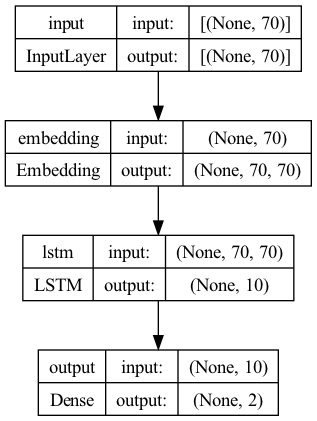

In [17]:
hyperparameters_1 = {
    'pX': X_train['normalize_comment'], 
    'py': y_train, 
    'pnum_words': None, 
    'pseq_length': None,
    'pno_units': 10, 
    'pdropout': 0.2, 
    'pbatch_size': 32, 
    'pepochs': 10, 
    'psave_weights': './models/lstm_model_comments_1.h5'
}

model_1 = DeepModel.SentimentLSTM()
model_1.define(**hyperparameters_1)
model_1.model.summary()
plot_model(model_1.model, to_file='./images/lstm_model_comments_1.png', show_shapes=True, show_layer_names=True)

Bây giờ ta tiến hành training model.

In [18]:
model_1.fit(**hyperparameters_1)

Epoch 1/10
320/320 [==============================] - 22s 62ms/step - loss: 0.4539 - accuracy: 0.8206 - val_loss: 0.3316 - val_accuracy: 0.8681
Epoch 2/10
320/320 [==============================] - 19s 58ms/step - loss: 0.2820 - accuracy: 0.8947 - val_loss: 0.3218 - val_accuracy: 0.8716
Epoch 3/10
320/320 [==============================] - 19s 59ms/step - loss: 0.2394 - accuracy: 0.9150 - val_loss: 0.3171 - val_accuracy: 0.8769
Epoch 4/10
320/320 [==============================] - 19s 59ms/step - loss: 0.2148 - accuracy: 0.9224 - val_loss: 0.3132 - val_accuracy: 0.8760
Epoch 5/10
320/320 [==============================] - 19s 58ms/step - loss: 0.1956 - accuracy: 0.9311 - val_loss: 0.3185 - val_accuracy: 0.8777
Epoch 6/10
320/320 [==============================] - 19s 59ms/step - loss: 0.1798 - accuracy: 0.9358 - val_loss: 0.3160 - val_accuracy: 0.8786
Epoch 7/10
320/320 [==============================] - 19s 58ms/step - loss: 0.1675 - accuracy: 0.9424 - val_loss: 0.3356 - val_accuracy:

In [19]:
!tensorboard --logdir ./tb_log_sentiment --port 6006 --host localhost


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.9.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C


<!-- ![](./images/13.png) -->
<img src="./images/13.png" width="450">


> **Nhận xét**:
> * Hai biểu đồ trên lần lượt thể hiện giá trị accuracy và loss value qua 10 epoch với đường màu xanh là của **validation data** và hồng là của **training data** được vẽ bằng TensorBoard. Có thể thấy kể từ epoch thứ 2 trở đi thì loss value có xu hướng đi xuống ở training data và đi lên ở valudation. Lúc này nhờ cơ thế CheckPoint của TensorFlow mà các weight tại thời điểm này được lưu lại và ta có thể kiểm tra sau này.

Tiếp theo, ta sẽ tokenizer cho test data để tiến hành đánh giá trên test data.

In [20]:
prediction_1 = model_1.predict(X_test['normalize_comment'])
prediction_1

89/89 [==============================] - 1s 8ms/step


,input,output_proba,output_class
0,đẹp nhẹ đường may nhiều đầu chỉ các...,"(0.4959207, 0.50407934)",1
1,giao hàng nhanh đóng gói sản phẩm cẩn ...,"(7.33297e-05, 0.9999267)",1
2,quần đẹp lắm thân thiện nhiều o,"(0.00047754217, 0.99952245)",1
3,ui xinh lắm luôn ship nhanh nưa,"(3.723158e-06, 0.9999963)",1
4,chất lượng tốt giao hàng nhanh nhân v...,"(0.00062082126, 0.99937916)",1
...,...,...,...
2836,chất hơi mềm quá nói chuyện vẫn đư...,"(0.36204994, 0.6379501)",1
2837,nhìn hình tưởng quần dày có thể mạ...,"(0.99967957, 0.00032048952)",0
2838,sản phẩm lủng rách nhiều chổ mua cái...,"(0.99997294, 2.7002601e-05)",0
2839,cay vừa mua không hôm sau giảm không,"(0.9999666, 3.337355e-05)",0


              precision    recall  f1-score   support

    Negative       0.86      0.90      0.88      1438
    Positive       0.89      0.85      0.87      1403

    accuracy                           0.87      2841
   macro avg       0.87      0.87      0.87      2841
weighted avg       0.87      0.87      0.87      2841



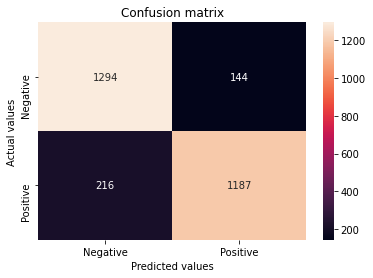

In [21]:
Model.confusionMatrix(y_test, prediction_1['output_class'])

> **Nhận xét**:
> * Ta có thể thấy rõ ràng rằng dù độ chính xác của model LSTM khá cao hơn 85%, với việc để các hyper-params cho TensorFlow tự quyết thì model có khả năng dự đoán cân bằng trên cả hai class là negative và postive, ta không cần phải kiểm tra lại bằng ROC-AUC.

Do ta có áp dụng checkpoint trong model để lưu lại các bộ tham số tốt nhất trong quá trình training, ta có thể lấy bộ tham số mà có validation loss thấp nhất để update trọng số cho model.

In [22]:
model_uw_1 = DeepModel.SentimentLSTM()
model_uw_1.define(**hyperparameters_1)
model_uw_1.model.load_weights("./models/lstm_model_comments_1/weights/04-0.313169.h5")

In [23]:
prediction_uw_1 = model_uw_1.predict(X_test['normalize_comment'])
prediction_uw_1

89/89 [==============================] - 1s 8ms/step


,input,output_proba,output_class
0,đẹp nhẹ đường may nhiều đầu chỉ các...,"(0.8266383, 0.17336166)",0
1,giao hàng nhanh đóng gói sản phẩm cẩn ...,"(0.0016991477, 0.99830085)",1
2,quần đẹp lắm thân thiện nhiều o,"(0.0030696124, 0.9969304)",1
3,ui xinh lắm luôn ship nhanh nưa,"(0.00012920643, 0.9998708)",1
4,chất lượng tốt giao hàng nhanh nhân v...,"(0.00032223584, 0.9996778)",1
...,...,...,...
2836,chất hơi mềm quá nói chuyện vẫn đư...,"(0.061082214, 0.9389178)",1
2837,nhìn hình tưởng quần dày có thể mạ...,"(0.99116737, 0.008832699)",0
2838,sản phẩm lủng rách nhiều chổ mua cái...,"(0.99951494, 0.00048503513)",0
2839,cay vừa mua không hôm sau giảm không,"(0.9998167, 0.00018328373)",0


              precision    recall  f1-score   support

    Negative       0.87      0.89      0.88      1438
    Positive       0.89      0.87      0.88      1403

    accuracy                           0.88      2841
   macro avg       0.88      0.88      0.88      2841
weighted avg       0.88      0.88      0.88      2841



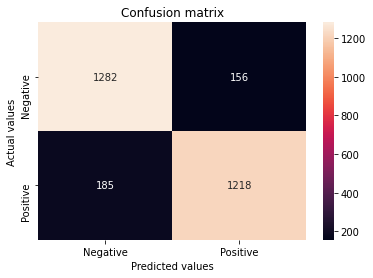

In [24]:
Model.confusionMatrix(y_test, prediction_uw_1['output_class'])

> **Nhận xét**:
> * Ta thấy rằng nếu nhìn vào các chỉ số như **precision**, **recall** và **F1-score** thì model được update bởi weight ở tại epoch thứ hai này hoạt động cho hiệu suất thậm chí tốt hơn một ít dù chỉ mới trải qua 2 epoch.

Ta sẽ đào tạo một model thứ hai với các hyper-params là `num_word` và `maxlen` lần lượt là 3000 và 100, ở project hai ta đã tính được toàn bộ data của ta có khoảng loanh quanh 3000 từ và các comment hay có độ dài là 100 và sử dụng 15 neuron ở LSTM layer.

Ta sẽ định nghĩa model sau đó cho training, dự đoán và đánh giá.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 70)            249830    
                                                                 
 lstm (LSTM)                 (None, 15)                5160      
                                                                 
 output (Dense)              (None, 2)                 32        
                                                                 
Total params: 255,022
Trainable params: 255,022
Non-trainable params: 0
_________________________________________________________________


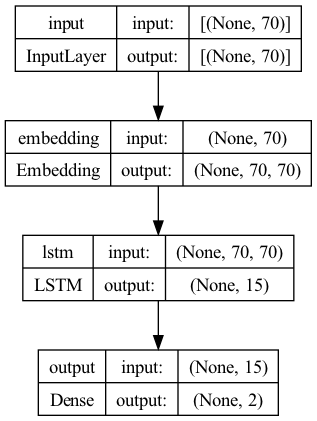

In [29]:
hyperparameters_2 = {
    'pX': X_train['normalize_comment'], 
    'py': y_train, 
    'pnum_words': 3000, 
    'pseq_length': 70,
    'pno_units': 15, 
    'pdropout': 0.3, 
    'pbatch_size': 32, 
    'pepochs': 10, 
    'psave_weights': './models/lstm_model_comments_2.h5'
}

model_2 = DeepModel.SentimentLSTM()
model_2.define(**hyperparameters_2)
model_2.model.summary()
plot_model(model_2.model, to_file='./images/lstm_model_comments_2.png', 
           show_shapes=True, show_layer_names=True)

In [30]:
model_2.fit(**hyperparameters_2)

Epoch 1/10
320/320 [==============================] - 28s 78ms/step - loss: 0.4364 - accuracy: 0.8161 - val_loss: 0.3288 - val_accuracy: 0.8760
Epoch 2/10
  1/320 [..............................] - ETA: 37s - loss: 0.3544 - accuracy: 0.8750

KeyboardInterrupt: 

In [27]:
!tensorboard --logdir ./tb_log_sentiment --port 6006


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [28]:
prediction_2 = model_2.predict(X_test['normalize_comment'])
prediction_2

89/89 [==============================] - 1s 7ms/step


,input,output_proba,output_class
0,đẹp nhẹ đường may nhiều đầu chỉ các...,"(0.53363544, 0.46636462)",0
1,giao hàng nhanh đóng gói sản phẩm cẩn ...,"(0.00031957173, 0.9996804)",1
2,quần đẹp lắm thân thiện nhiều o,"(0.005640654, 0.9943593)",1
3,ui xinh lắm luôn ship nhanh nưa,"(1.5681956e-06, 0.99999845)",1
4,chất lượng tốt giao hàng nhanh nhân v...,"(6.1814666e-05, 0.99993813)",1
...,...,...,...
2836,chất hơi mềm quá nói chuyện vẫn đư...,"(0.06391417, 0.9360859)",1
2837,nhìn hình tưởng quần dày có thể mạ...,"(0.9986689, 0.0013311356)",0
2838,sản phẩm lủng rách nhiều chổ mua cái...,"(0.9999634, 3.6623438e-05)",0
2839,cay vừa mua không hôm sau giảm không,"(0.9999337, 6.633482e-05)",0


              precision    recall  f1-score   support

    Negative       0.87      0.88      0.88      1438
    Positive       0.88      0.86      0.87      1403

    accuracy                           0.87      2841
   macro avg       0.87      0.87      0.87      2841
weighted avg       0.87      0.87      0.87      2841



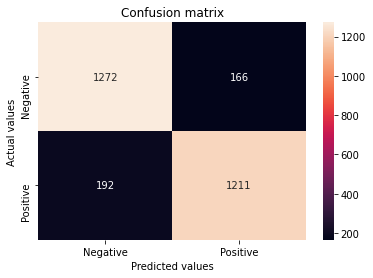

In [16]:
Model.confusionMatrix(y_test, prediction_2['output_class'])

> **Nhận xét**:
> * Độ chính xác của model 2 này là 86 phần trăm.
> * Nhưng ta nên đặt câu hỏi vì sao đã qua 2 model có kiến trúc khác nhau rất nhiều nhưng độ chính xác vẫn loanh quanh 86, 87%.

In [17]:
model_uw_2 = DeepModel.SentimentLSTM()
model_uw_2.define(**hyperparameters_2)
model_uw_2.model.load_weights("./models/lstm_model_comments_2/weights/02-0.325247.h5")

In [18]:
prediction_uw_2 = model_uw_2.predict(X_test['normalize_comment'])
prediction_uw_2

89/89 [==============================] - 1s 9ms/step


,input,output_proba,output_class
0,đẹp nhẹ đường may nhiều đầu chỉ các...,"(0.8633138, 0.13668613)",0
1,giao hàng nhanh đóng gói sản phẩm cẩn ...,"(0.0010652067, 0.9989348)",1
2,quần đẹp lắm thân thiện nhiều o,"(0.0062824017, 0.99371755)",1
3,ui xinh lắm luôn ship nhanh nưa,"(0.000619642, 0.99938035)",1
4,chất lượng tốt giao hàng nhanh nhân v...,"(0.00069103093, 0.99930894)",1
...,...,...,...
2836,chất hơi mềm quá nói chuyện vẫn đư...,"(0.014987079, 0.9850129)",1
2837,nhìn hình tưởng quần dày có thể mạ...,"(0.15381914, 0.84618086)",1
2838,sản phẩm lủng rách nhiều chổ mua cái...,"(0.9985297, 0.0014703479)",0
2839,cay vừa mua không hôm sau giảm không,"(0.9986547, 0.0013452299)",0


              precision    recall  f1-score   support

    Negative       0.88      0.86      0.87      1438
    Positive       0.86      0.88      0.87      1403

    accuracy                           0.87      2841
   macro avg       0.87      0.87      0.87      2841
weighted avg       0.87      0.87      0.87      2841



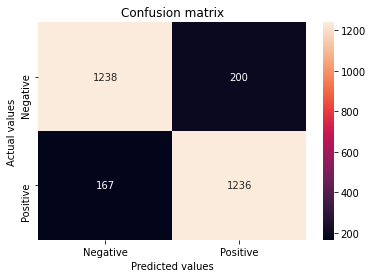

In [19]:
Model.confusionMatrix(y_test, prediction_uw_2['output_class'])

> **Nhận xét**:
> * Độ chính xác lúc này 87%.
> * Nếu ta đào tạo quá 10 epoch thì càng ngày bị overfitting, nhưng nếu ta thay đổi kiến trúc của model thì độ chính xác luôn loanh quanh 86, 87%. Như vậy đây có phải là độ chính xác tối đa mà model LSTM có thể đạt được hoặc là do chính data của ta bị variance error do có sự chồng chéo data giữa nagative và postive ở các comment 3 sao.

Bây giờ ta sẽ lưu lại các model này thành file `*.h5` và các vectorizer tương ứng thành file `*.pickle`.

In [20]:
model_1.save("./models/lstm_model_comments_1/lstm_model_comments_1.h5", "./models/lstm_model_comments_1/lstm_tokenizer_comments_1.pickle")
model_uw_1.save("./models/lstm_model_comments_1/lstm_model_comments_uw_1.h5", "./models/lstm_model_comments_1/lstm_tokenizer_comments_uw_1.pickle")

(<keras.preprocessing.text.Tokenizer object at 0x7fc12e010af0>, 70) has been saved at ./models/lstm_model_comments_1/lstm_tokenizer_comments_1.pickle.
📢 Model has been saved at ./models/lstm_model_comments_1/lstm_model_comments_1.h5 - Tokenizer has been saved at ./models/lstm_model_comments_1/lstm_tokenizer_comments_1.pickle.
(<keras.preprocessing.text.Tokenizer object at 0x7fc133cc7e20>, 70) has been saved at ./models/lstm_model_comments_1/lstm_tokenizer_comments_uw_1.pickle.
📢 Model has been saved at ./models/lstm_model_comments_1/lstm_model_comments_uw_1.h5 - Tokenizer has been saved at ./models/lstm_model_comments_1/lstm_tokenizer_comments_uw_1.pickle.


In [21]:
model_2.save("./models/lstm_model_comments_2/lstm_model_comments_2.h5", "./models/lstm_model_comments_2/lstm_tokenizer_comments_2.pickle")
model_uw_2.save("./models/lstm_model_comments_2/lstm_model_comments_uw_2.h5", "./models/lstm_model_comments_2/lstm_tokenizer_comments_uw_2.pickle")

(<keras.preprocessing.text.Tokenizer object at 0x7fc134a457f0>, 70) has been saved at ./models/lstm_model_comments_2/lstm_tokenizer_comments_2.pickle.
📢 Model has been saved at ./models/lstm_model_comments_2/lstm_model_comments_2.h5 - Tokenizer has been saved at ./models/lstm_model_comments_2/lstm_tokenizer_comments_2.pickle.
(<keras.preprocessing.text.Tokenizer object at 0x7fc12e7904f0>, 70) has been saved at ./models/lstm_model_comments_2/lstm_tokenizer_comments_uw_2.pickle.
📢 Model has been saved at ./models/lstm_model_comments_2/lstm_model_comments_uw_2.h5 - Tokenizer has been saved at ./models/lstm_model_comments_2/lstm_tokenizer_comments_uw_2.pickle.


Bây giờ chúng ta sẽ tiến hành Hyper Parameters bằng phương pháp HyperBand được đề xuất vào năm 2016. Đây là bài báo đó [https://arxiv.org/pdf/1603.06560.pdf](https://arxiv.org/pdf/1603.06560.pdf). Ý tưởng của phương pháp này là HyperBand sẽ random ra một vài hyper-params set ban đầu. Tiếp theo nó sẽ tiến hành đào tạo các model này và thực hiện đánh giá dựa trên loss value của train hoặc test do ta quy định. Tiếp theo nó sẽ tiến hành chọn lọc dựa trên các công thức để chọn ra các hyperparam set có loss thấp nhất và loại bỏ đi các hyperparams set cho hiệu suất kém. Với từng hyperparams set được chọn lọc này nó sẽ đào tạo lại và tiếp tục loại bỏ và đào tạo lại cho đến khi còn lại model tốt nhất.

Bài viết gốc của tác giả đọc sẽ khó hiểu và nặng về toán học, nên ta có thể đọc tại đây để dễ hiểu hơn [https://medium.com/data-from-the-trenches/a-slightly-better-budget-allocation-for-hyperband-bbd45af14481](https://medium.com/data-from-the-trenches/a-slightly-better-budget-allocation-for-hyperband-bbd45af14481).

Bây giờ ta sẽ tạo một hàm `get_params()` là một Random-Search ra một hyperparam-set. Tiếp theo hàm `try_params()` sẽ nhận vào hyperparam set phát sinh từ `get_params()` và tiến hành training. Hai hàm này sẽ được bỏ vào một object `Hyperband` như là các tham số, là object này sẽ thực hiện tính toán và trả ra hyperparams set tốt nhất.

In [47]:
def get_params():
    pbatch_size = np.random.choice(np.arange(5, 100, 10))
    pnum_words = np.random.choice(np.arange(2000, 3000, 10))
    optimizers = np.random.choice(['rmsprop', 'adam', 'adadelta'])
    pdropout = np.random.choice(np.linspace(0.1, 0.5, 10))
    pno_units = np.random.choice(np.arange(10, 50, 10))
    pseq_length = np.random.choice(np.arange(50, 200, 10))
    
    return {
        'pX': X_train['normalize_comment'], 
        'py': y_train, 
        'pnum_words': pnum_words, 
        'pseq_length': pseq_length,
        'pno_units': pno_units, 
        'pdropout': pdropout, 
        'poptimizers': optimizers,
        'pbatch_size': pbatch_size, 
        'pepochs': 10, 
        'psave_weights': './models/lstm_model_comments_3.h5'
    }

In [48]:
def try_params(**kwargs):
    model = DeepModel.SentimentLSTM()
    model.define(**kwargs)
    model.fit(**kwargs)

    return {"loss": model.evaluation()}


hb = DeepModel.Hyperband(get_params, try_params)
results = hb.run()

print(results)

> **Nhận xét**:
> * Ở đây nhóm đã tiến hành ngắt quá trình đào tạo lại, hình dưới đây được chụp từ file `hyperband.txt` - file này ghi lại lịch sử của quá trình optimization, ta thấy rằng:
> ![](./images/17.png)
>   * Dù trải qua 20 lần đào tạo lại các model dựa trên các hyperparam-set khác nhau cho validation loss thấp nhất, nhưng giá trị này vẫn lớn hơn 0.3 tương tự như `model_1` và `model_2` mà ta đào tạo ban đầu, xem ra đây có thể là hiệu suất tốt nhất mà model LSTM của ta có thể làm được. 
>   * Từ đây góp phần cho ta chắc chắn hơn rằng dataset comments của chúng ta đang thực sự bị variance error.